In [5]:
from yuning_util.dev_mode import DevMode
dev_mode = DevMode(pkg='k-seq')
dev_mode.on()

In [6]:
from importlib import reload
from k_seq.model import count
reload(count)
import numpy as np

In [64]:
count.MultiNomial.func(p=[1, 3, 1, 1], N=[10, 3, 200, 1])

TypeError: only size-1 arrays can be converted to Python scalars

In [71]:
multinomial.rvs(n=[5, 1], p=[0.1, 0.9])

TypeError: only size-1 arrays can be converted to Python scalars

# Count models with `statsmodel` package

In [1]:
import statsmodels as sm

In [32]:
from scipy.stats import nbinom

nbinom.pmf(k=[1, 2, 3], n=[2, 1, 1], p=[0.2, 0.8, 0.8])

array([0.064 , 0.032 , 0.0064])

In [104]:
from statsmodels.base.model import GenericLikelihoodModel

class NBinom(GenericLikelihoodModel):
    
    def __init__(self, endog, exog=None, **kwargs):
        super().__init__(endog, exog=None, **kwargs)
        self.nparams = 2
    
    @staticmethod
    def _convert_params(mu, s):
        """
        Convert mean/dispersion parameterization (mu, s) of a negative binomial that
          mean = mu
          var = mu + 1/s * mu ** 2
        to the ones scipy supports NB(n, p) ~ number of success, where
          n: num. of failure
          p: prob of single failure
         where:
           mean: (1-p)n/p
           var: (1-p)n/(p**2)

        See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
        """
        var = mu + 1/s * mu ** 2
        p = mu / var
        n = s
        return n, p
    
    
    def nloglikeobs(self, params):
        """Calculation of negative likelihood of single observation"""
        
        n, p = self._convert_params(*params)
        from scipy.stats import nbinom
        return -nbinom.logpmf(k=self.endog, n=n, p=p)
    
    def fit(self, start_param=None, maxiter=10000, maxfun=5000, **kwargs):
        # self.exog_names.append('alpha')
        if start_param is None:
            start_param = (1, 0.5)
        return super().fit(start_param=start_param,
                           maxiter=maxiter,
                           maxfun=maxfun, **kwargs)


In [25]:
from scipy.stats import multinomial
multinomial.logpmf?

In [59]:
from scipy.stats import nbinom
data = nbinom.rvs(*NBinom._convert_params(3, 1000000), size=50)
model = NBinom(endog=data)
model_res = model.fit()
model_res.summary()

NameError: name 'NBinom' is not defined

In [58]:
multinomial.logpmf(n=[10, 12], p=[0.1, 0.5, 0.4], x=[[2, 0, 8], [9, 3, 0]])

array([ -8.12883355, -17.40907983])

In [5]:

multi_nom = count.MultiNomial(N=100, p=[0.1, 0.4, 0.8])

In [32]:
y = np.array([[0, 1, 3, 1],
              [1, 3, 2, 1]])
y.sum()

12

## Multinomial model

In [282]:
reload(count)
MultiNomial = count.MultiNomial

def rel_abun_simulator(num_feat=1e5, one_pct=0.8):
    from scipy.stats import expon
    import numpy as np
    p = expon.rvs(size=int(num_feat))
    mask = np.random.choice(np.arange(num_feat, dtype=int), size=int(one_pct * num_feat))
    p[mask] = p.min()
    return p/p.sum()

rel_abun_simulator()

array([1.86490371e-10, 1.86490371e-10, 1.86490371e-10, ...,
       3.67705410e-06, 4.01231777e-05, 1.86490371e-10])

In [283]:
p = rel_abun_simulator(num_feat=500, one_pct=0.8)
simulator = MultiNomial(p=p, N=1e6)
y = simulator.predict(size=3, seed=23)

In [284]:
y.shape

(3, 500)

In [285]:
model = MultiNomial(y=y)

In [286]:
res = model.mle_fit_scipy()

In [287]:
from scipy.stats import pearsonr
print(pearsonr(res.x, p))
res

(0.9999714948695093, 0.0)


     fun: 1401.4737929900487
     jac: array([ 2.17067500e+04,  1.50000000e+00,  1.10116667e+04,  9.99999583e+05,
        2.91671753e-01,  4.60416718e+01,  2.54166718e+01,  3.57500000e+01,
        2.17067500e+04,  4.00000000e+00,  1.10116667e+04,  5.41671753e-01,
        9.99999583e+05,  5.54625000e+03,  2.17067500e+04,  7.37695834e+03,
        1.10116667e+04,  7.37695834e+03,  2.17067500e+04,  1.10116667e+04,
        1.10116667e+04,  9.99999583e+05,  7.37695834e+03,  1.10116667e+04,
        4.16671753e-01,  1.10116667e+04,  0.00000000e+00,  2.17067500e+04,
        5.54625000e+03,  1.10116667e+04,  7.37695834e+03,  9.99999583e+05,
        1.10116667e+04,  1.10116667e+04,  1.00000000e+00,  7.37695834e+03,
        5.83343506e-01,  1.10116667e+04,  1.00000000e+01,  3.45834351e+00,
        1.25000000e-01,  7.54167175e+00,  8.33435059e-02,  9.99999583e+05,
        5.16667175e+00,  2.27083435e+01,  9.99999583e+05,  1.66667175e+00,
        1.10116667e+04,  9.99999583e+05,  5.54625000e+03,  1.

limit_output extension: Maximum message size of 10000 exceeded with 18451 characters

In [146]:
# from scipy.stats import multinomial

multinomial.logpmf(n=[5, 4], p=[0.3, 0.7], x=[[3, 2], [1, 3]])

array([-2.02268321, -0.88770328])

0

# Tensorflow engine test

In [4]:
import tensorflow_probability as tfp

tfd = tfp.distributions

In [99]:
# follow is an example from Jeff Pollock https://jeffpollock9.github.io/maximum-likelihood-estimation-with-tensorflow-probability-and-pystan/
# of fitting a Bernoulli distribution

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

# simulate the dataset

N = 1_000_000  # num_observation
P = 250 # parameter

tf.random.set_random_seed(23)

alpha = tfd.Normal(0.666, 1.0).sample() # alpha is a tensor with shape []
beta = tfd.Normal(0.0, 3.14).sample([P, 1]) # tensor with shape [250, 1], vertical vector

x = tfd.Normal(0.0, 1.0).sample([N, P]) # sampled tensor with shape [1_000_000, 250]
y = tfd.Bernoulli(alpha + x @ beta).sample()

# define the model

def loss(param, x, y):
    """Negative Log likelihood as loss, reduced on all observations"""
    alpha = param[0]
    beta = tf.expand_dims(param[1:], 1)
    model = tfd.Bernoulli(alpha + x @ beta)
    return -tf.reduce_sum(model.log_prob(y))

def loss_and_gradient(param, x, y):
    """pass a value and gradient object to tfp.optimizer.lbfgs_minimize,
    conditioned on the given data: (x, y)
    """
    return tfp.math.value_and_gradient(lambda param: loss(param, x, y),
                                       param)

def fit(x, y):
    """a fitting node to conduct fitting"""
    init = tf.zeros(tf.shape(x)[1] + 1)  # get the dimension of params
    opt = tfp.optimizer.lbfgs_minimize(
        lambda param: loss_and_gradient(param, x, y), init, max_iterations=1000
    )
    return opt

# run training
import time

with tf.Session() as sess:
    start = time.time()
    mle = fit(x, y)
    res = sess.run(mle)
    end = time.time()
    print(f"computation time: {end - start:.4f} seconds")
    
#     print(f"converged: {mle.}")
#     print(f"iterations: {mle.num_iterations}")

computation time: 17.1205 seconds


In [102]:
res.

SyntaxError: invalid syntax (<ipython-input-102-8ccdd3977c84>, line 1)

In [23]:
import tensorflow as tf

sess = tf.Session()

x = tf.constant([23, 1, 2,
                 0, 1, 2,
                 12, 12, 1])
y = tf.reshape(x, [3, -1])

with sess.as_default():
    print(y.eval())

[[23  1  2]
 [ 0  1  2]
 [12 12  1]]


## Tensorflow based count model

In [114]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

def reparameterization(theta, psi, phi):
    """Reparameterize p0, k, and A to avoid constraints
    P is the number of features
    
    Args:
        theta: shape [P] tensor
        psi: shape [P] tensor
        phi: shape [P] tensor
    
    Returns:
        p0: shape [P] tensor
        k: shape [P] tensor
        A: shape [P] tensor
    """
    
    p0 = tf.math.softmax(theta)
    k = tf.math.exp(psi)
    A = tf.exp(phi) / (1 + tf.exp(phi))
    
    return p0, k, A


def kinetic_model(p0, k, A, c, alpha, t):
    """A pseudo-first order kinetic model
    input intial pool and parameters of observation
    output pool composition for all observations shape [N, P]
    """
    
    
    # expand c(shape [P]) to c_repeat([N, P])
    
    c_rep = tf.tile(tf.expand_dims(c, -1), [1, tf.shape(p0)[0]])
    frac = tf.multiply(1 - tf.exp(-alpha * t * tf.multiply(c_rep, k)), A)
    p = tf.multiply(frac, p0)
    
    return tf.divide(p, tf.expand_dims(tf.reduce_sum(input_tensor=p, axis=1), -1))


def loss(params_1d, c, alpha, t, y, mask):
    """Negative Log likelihood as loss, reduced on all observations"""
    
    params = tf.reshape(params_1d, [3, -1])
    theta = params[0]
    psi = params[1]
    phi = params[2]
    
    p0, k, A = reparameterization(theta, psi, phi)
    
    probs_reacted = kinetic_model(p0, k, A, tf.boolean_mask(c, mask), alpha, t)
    probs_init = tf.tile(tf.expand_dims(p0, 0), [np.sum(~mask), 1])
    
    #print(y)
    N = tf.reduce_sum(y, axis=-1)
    #print(N)
    total_count = tf.boolean_mask(N, mask)
    model_reacted = tfd.Multinomial(total_count=tf.boolean_mask(N, mask), probs=probs_reacted)
    total_count = tf.boolean_mask(N, ~mask)
    model_init = tfd.Multinomial(total_count=tf.boolean_mask(N, ~mask), probs=probs_init)
    
    return -tf.reduce_sum(model_reacted.log_prob(tf.boolean_mask(y, mask)))-tf.reduce_sum(model_init.log_prob(tf.boolean_mask(y, ~mask)))

def loss_and_gradient(params, alpha, t, c, y, mask):
    """pass a value and gradient object to tfp.optimizer.lbfgs_minimize,
    conditioned on the given data: (c, y)
    """
    value, gradient = tfp.math.value_and_gradient(
        lambda params: loss(params, c=c, y=y, alpha=alpha, t=t, mask=mask),
        params
    )
#     print(value)
#     print(gradient)
    return value, tf.reshape(gradient, [-1])

def fit_count_model(var, count, sample_mask, alpha=0.479, t=90, method='lbfgs', init_method='uniform'):
    """a fitting node to conduct fitting
    var: controlled variable, x, here is concentration (c)
    count: dependent variable, y
    sample_mask: boolean mask indicate init pool (False) or reacted pool (True)
    """
    
    if init_method.lower() in ['unif', 'uniform']:
        param_init = tf.zeros([3 * tf.shape(count)[1]])  # initialize params [theta, psi, phi] with zero, then
    elif init_method.lower() in ['average', 'avg']:
        p0_init = count[var < 0].sum(0) + 0.01
        theta_init = np.log(p0_init)
        param_init = tf.convert_to_tensor(
            np.concatenate(
                [theta_init, np.zeros_like(theta_init), np.zeros_like(theta_init)]
            ), dtype=np.float32
        )
    opt = tfp.optimizer.lbfgs_minimize(
        lambda params: loss_and_gradient(params, c=var, y=count, alpha=alpha, t=t, mask=sample_mask),
        initial_position=param_init, max_iterations=1000
    )
    return opt


In [41]:
def pool_simulator(ribo_num, seq_to_ribo_ratio, p0_param, a_param, k_param, c_list, N_list, rnd_seed=23, save_to=None):
    from k_seq.model import pool, count, kinetic
    from k_seq.data import simu
    import numpy as np
    import pandas as pd
    
    p0 = simu.pSampler(n=ribo_num).from_lognormal(loc=p0_param['loc'], scale=p0_param['scale'])
    A = simu.ASampler(n=ribo_num).from_uniform(low=a_param['low'], high=a_param['high'])
    k = simu.kSampler(n=ribo_num).from_lognormal(c95=k_param['c95'])
    
    truth = pd.DataFrame({'p0': p0, 'a': A, 'k':k})
    truth.index.name = 'seq'
    
    pool_model = pool.PoolModel(count_model=count.MultiNomial, kinetic_model=kinetic.BYOModel)
    pool_simulator = simu.Simulator(model=pool_model,
                                    repeat=3,
                                    parameters=[{'c':c, 'N':N} for c, N in zip(c_list, N_list)],
                                    p0=p0, A=A, k=k, seed=rnd_seed)
    X = pd.DataFrame({sample: {'c': params['c'] if params['c'] >= 0 else np.nan,
                               'n': params['N']}
                      for sample, params in pool_simulator.parameters.items()})
    y = pool_simulator.to_DataFrame()
    y.index.name = 'seq'
    
    if save_to is not None:
        from pathlib import Path
        save_path = Path(save_to)
        if save_path.suffix == '':
            save_path.mkdir(parents=True, exist_ok=True)
            X.to_csv(f'{save_path}/X.csv')
            y.to_csv(f'{save_path}/y.csv')
            truth.to_csv(f'{save_path}/truth.csv')
        else:
            raise TypeError('save_to should be a directory')
        
    return X, y, truth
    

In [11]:
from pathlib import Path

In [48]:
import numpy as np

ribo_num = int(1e3)
seq_to_ribo_ratio = int(100)

p0_param = {'loc': 0, 'scale':0}
a_param = {'low': 0, 'high': 1}
k_param = {'c95': [0.5, 100]}

c_list = np.array([-1, 2, 10, 50, 250, 1250]) * 1e-6 #uM --> M
N_list = np.repeat(ribo_num * seq_to_ribo_ratio, len(c_list))

X, y, truth = pool_simulator(
    ribo_num=ribo_num,
    seq_to_ribo_ratio=seq_to_ribo_ratio,
    p0_param=p0_param,
    a_param=a_param,
    k_param=k_param,
    c_list=c_list,
    N_list=N_list,
    rnd_seed=23,
    save_to=f"/mnt/storage/projects/k-seq/datasets/count_tests/seq_{ribo_num}_depth_{seq_to_ribo_ratio}_p0var{p0_param['scale']}"
)

''

In [135]:
import time
import tensorflow as tf

tf.reset_default_graph()

with tf.Session() as sess:
    start = time.time()
    var = np.array([params['c'] for params in pool_simulator.parameters.values()], dtype=np.float32)
    print(var)
    count = pool_simulator.to_numpy().astype(np.float32)
    sample_mask = np.array([c > 0 for c in var])
    print(sample_mask)
    mle = fit_count_model(var=var, count=count, sample_mask=sample_mask, init_method='average')
    res = sess.run(mle)
    end = time.time()
    print(f"computation time: {end - start:.4f} seconds")
    assert res.converged

[-1.00e-03 -1.00e-03 -1.00e-03  2.00e-03  2.00e-03  2.00e-03  1.00e-02
  1.00e-02  1.00e-02  5.00e-02  5.00e-02  5.00e-02  2.50e-01  2.50e-01
  2.50e-01  1.25e+00  1.25e+00  1.25e+00]
[False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
computation time: 21.2129 seconds


In [ ]:
def parse_param(params):
    from collections import namedtuple
    import numpy as np
    from scipy.special import softmax
    
    params = np.reshape(params, [3, -1])
    theta = params[0]
    psi = params[1]
    phi = params[2]
    
    p0 = softmax(theta)
    k = np.exp(psi)
    A = np.exp(phi) / (1 + np.exp(phi))
    
    Params = namedtuple('Params', ['p0', 'k', 'A'])
    return Params(p0=p0, k=k, A=A)



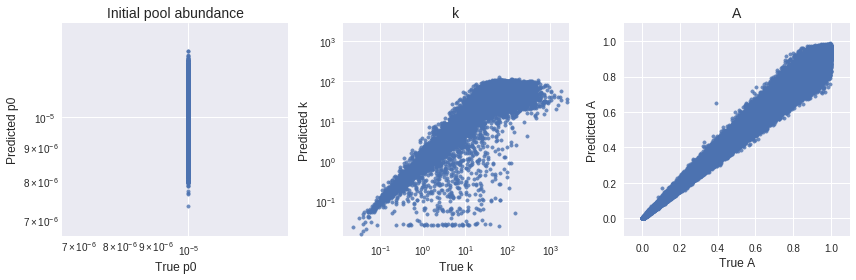

In [136]:
params = parse_param(res.position)

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

fig, axes = plt.subplots(1, 3, figsize=[12, 4])

axes[0].scatter(p0, params.p0, marker='.', alpha=0.8)
lim = (min(p0.min(), params.p0.min()) * 0.9, max(p0.max(), params.p0.max()) * 1.1)
axes[0].set_xlim(lim)
axes[0].set_ylim(lim)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('Initial pool abundance', fontsize=14)
axes[0].set_xlabel('True p0', fontsize=12)
axes[0].set_ylabel('Predicted p0', fontsize=12)


axes[1].scatter(k, params.k, marker='.', alpha=0.8)
lim = (min(k.min(), params.k.min()) * 0.9, max(k.max(), params.k.max()) * 1.1)
axes[1].set_xlim(lim)
axes[1].set_ylim(lim)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('k', fontsize=14)
axes[1].set_xlabel('True k', fontsize=12)
axes[1].set_ylabel('Predicted k', fontsize=12)

axes[2].scatter(A, params.A, marker='.', alpha=0.8)
axes[2].set_xlim([-0.1, 1.1])
axes[2].set_ylim([-0.1, 1.1])
axes[2].set_title('A', fontsize=14)
axes[2].set_xlabel('True A', fontsize=12)
axes[2].set_ylabel('Predicted A', fontsize=12)

plt.tight_layout()
plt.show()

In [114]:
r

LBfgsOptimizerResults(converged=True, failed=False, num_iterations=82, num_objective_evaluations=270, position=array([-1.5478985 ,  0.38503692,  2.2707381 , ...,  0.        ,
        0.        ,  0.        ], dtype=float32), objective_value=889700.0, objective_gradient=array([-2.7492287,  7.0260572, -2.4329975, ...,  0.       ,  0.       ,
        0.       ], dtype=float32), position_deltas=array([[ 4.18663025e-04,  1.49667263e-04,  1.36613846e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.38279724e-04,  4.46259975e-04,  1.16825104e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.57131386e-04,  5.44369221e-04,  9.01222229e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.12001801e-03,  2.82883644e-04,  2.30312347e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.82008743e-03, -4.64022160e-05,  6.91413879e-06, ...,
         0.00000000e+00,  0.000000

# Pool Simulator

In [12]:
from k_seq.data import CountFileSet

bfo_data = CountFileSet.load_default(dataset='bfo')
bfo_data.load_data()

array([[     1],
       [     1],
       [     1],
       ...,
       [ 28860],
       [122377],
       [605843]])

In [59]:
from k_seq.model import pool, count, kinetic
from k_seq.data import simu
import pandas as pd
reload(pool)
reload(count)
reload(kinetic)
reload(simu)

# summarize following into a function

p0 = simu.pSampler(n=1e5).from_list(seqs['A-inputA'])
A = simu.ASampler(n=1e5).from_uniform(low=0, high=1)
k = simu.kSampler(n=1e5).from_lognormal(c95=[0.5, 50])
ribo_info = pd.DataFrame({'p0': p0, })

In [ ]:
p0 = simu.pSampler.from_list()

In [60]:
k

array([ 2.11322467, 54.20552086,  0.74818859, ...,  2.02509913,
       40.57007239, 16.27110082])

# Test the MLE using `cvxpy`


A full mle case will be:

$$
\mathcal{l} = \sum_{j=1}^J \sum_{i=1}^m n_{ji}\Large[ \log p_{0i} + \log A_i + \log(1-e^{-\alpha k_i})\Large] - 
$$

In [ ]:
def get_mle_problem(x, Y):
    import cvxpy as cp
